<a href="https://colab.research.google.com/github/deng232/DINO_SAM_Zoe/blob/main/DINO_SAM_Zoe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd Grounded-Segment-Anything/
!python -m pip install -e segment_anything
!python -m pip install -e GroundingDINO
# Midas require to use timm with version 0.6.12
!python -m pip install timm==0.6.12
!mkdir weights
!mkdir testinput
#download models
!wget -q -P \weights https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget -q -P \weights https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
Obtaining file:///content/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything
Obtaining file:///content/Grounded-Segment-Anything/GroundingDINO
  Preparing metadata (setup.py) ... done
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.5
    Uninstalling timm-0.9.5:
      Su

In [4]:
!wget -q -P \testinput https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q -P \testinput https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q -P \testinput https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q -P \testinput https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/Grounded-Segment-Anything/weights/sam_vit_h_4b8939.pth ; exist: True
final text_encoder_type: bert-base-uncased


Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


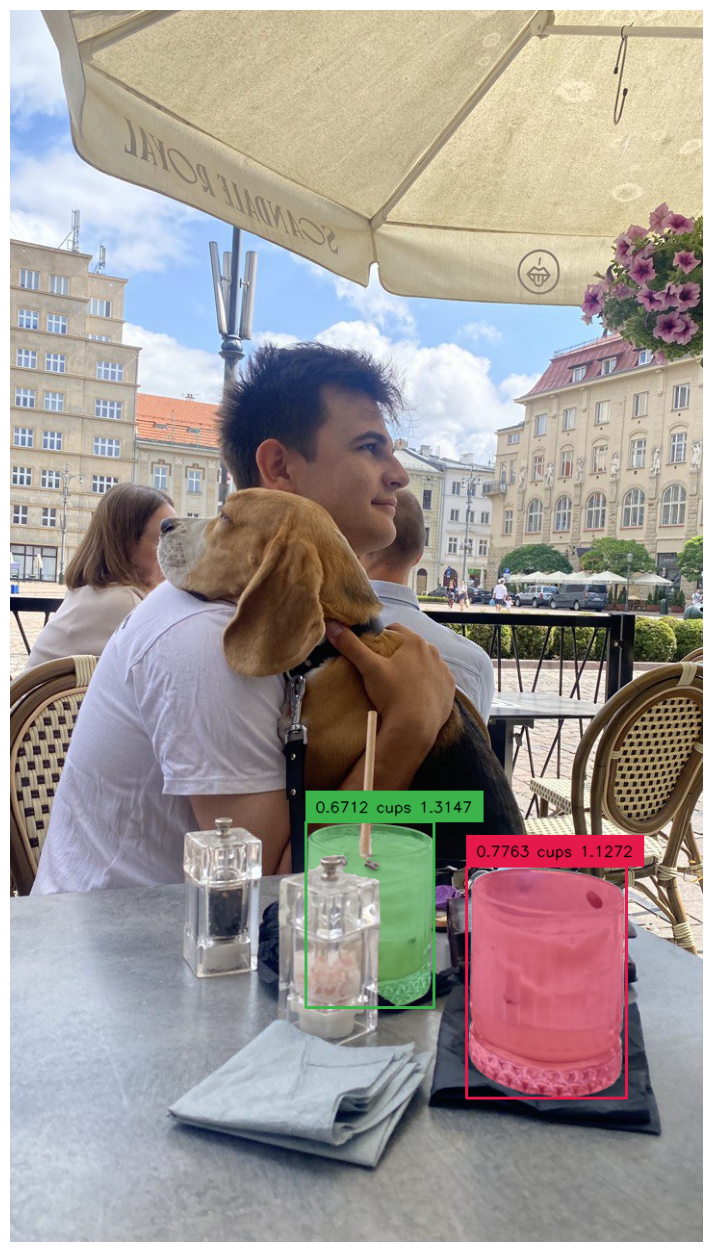

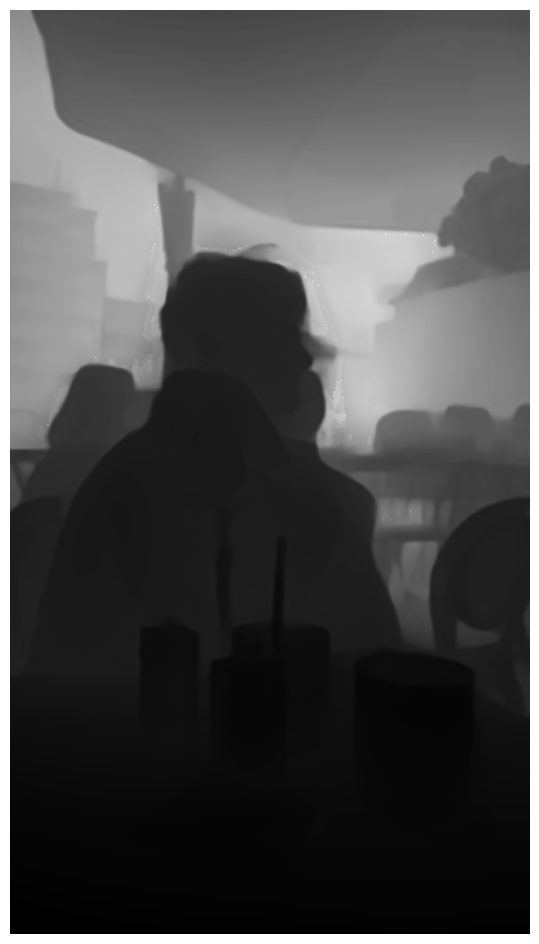

In [6]:
import supervision as sv
import os
import torch
import cv2
import numpy as np
import sys
sys.path.append('GroundingDINO')
sys.path.append('segment_anything')
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
from groundingdino.util.inference import Model
import sys

image = cv2.imread(os.path.join(os.getcwd(), 'testinput','dog-2.jpeg') )
CAPTIONS = "cups"

# loading Grounding DINO
DINO_CONFIG_PATH = os.path.join(
    os.getcwd(), "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(DINO_CONFIG_PATH, "; exist:", os.path.isfile(DINO_CONFIG_PATH))
DINO_WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
DINO_WEIGHTS_PATH = os.path.join(os.getcwd(), "weights", DINO_WEIGHTS_NAME)
SAM_WEIGHTS_NAME = "sam_vit_h_4b8939.pth"
SAM_WEIGHTS_PATH = os.path.join(os.getcwd(), "weights", SAM_WEIGHTS_NAME)
print(SAM_WEIGHTS_PATH, "; exist:", os.path.isfile(SAM_WEIGHTS_PATH))


DINO_model = Model(model_config_path=DINO_CONFIG_PATH,
                   model_checkpoint_path=DINO_WEIGHTS_PATH)

sam_predictor = SamPredictor(sam_model_registry['vit_h'](
    checkpoint=SAM_WEIGHTS_PATH).to(device=torch.device('cuda')))

model_zoe_nk = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True)
model_zoe_nk.to(torch.device('cuda'))

sam_predictor.set_image(image)
detections = DINO_model.predict_with_caption(
    image=image, caption=CAPTIONS, box_threshold=.55, text_threshold=.25)
detections[0].mask = [masks[np.argmax(scores)] for masks, scores, _ in map(
    lambda box: sam_predictor.predict(box=box, multimask_output=True), detections[0].xyxy)]

#depth_map = model_zoe_nk.infer_pil(image, output_type="numpy")
depth_map = model_zoe_nk.infer_pil(image, output_type="numpy",pad_input=False) # "pad_input = False" increase accuracy

# list of pixles of a masked region in depth_map
masklist = [depth_map[mask] for mask in detections[0].mask]

# size of the text in annotation
box_annotator = sv.BoxAnnotator(text_scale=.5)
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(
    scene=image, detections=detections[0])
#
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections[0], labels=[
                                         f"{confidence:.4f} {name} {average_depth:.4f}" for confidence, name, average_depth in
                                         zip(detections[0].confidence.tolist(), detections[1],
                                             [sum(mask)/len(mask) for mask in masklist])])


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
sv.plot_image(annotated_image, (16, 16))
sv.plot_image((depth_map))
